In [119]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("COHERE_API_KEY")


In [120]:
import os
import logging
import requests
import pandas as pd

from typing import List, Dict, Any, Optional
from langchain_core.tools import tool
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

# ==========================================
# Configuration
# ==========================================

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Service endpoints (can also be set via environment variables)
PRODUCT_SERVICE_URL = os.getenv("PRODUCT_SERVICE_URL", "http://localhost:8001")
ORDER_SERVICE_URL   = os.getenv("ORDER_SERVICE_URL",   "http://localhost:8002")

# Product Service Tools

In [122]:
# ==========================================
# Product Service Tools
# ==========================================

@tool
def search_products(query: str, top_k: int = 5) -> List[Dict[str, Any]]:
    """
    Search for products based on a text query using RAG.
    
    Args:
        query: Search query string
        top_k: Number of results to return (default: 5)
        
    Returns:
        List of product dictionaries containing details like title, description, price, etc.
    """
    try:
        response = requests.get(
            f"{PRODUCT_SERVICE_URL}/search",
            params={"query": query, "top_k": top_k}
        )
        response.raise_for_status()
        return response.json().get("results", [])
    except Exception as e:
        logger.error(f"Error searching products: {e}")
        return []

@tool
def search_product_by_category(category: str, query: str, top_k: int = 5) -> List[Dict[str, Any]]:
    """
    Search for products in a specific category.
    
    Args:
        category: Category to search in
        query: Search query string
        top_k: Number of results to return (default: 5)
        
    Returns:
        List of product dictionaries containing details like title, description, price, etc.
    """
    try:
        response = requests.get(
            f"{PRODUCT_SERVICE_URL}/search/category",
            params={"category": category, "query": query, "top_k": top_k}
        )
        response.raise_for_status()
        return response.json().get("results", [])
    except Exception as e:
        logger.error(f"Error searching products by category: {e}")
        return []

@tool
def get_top_rated_products(category: Optional[str] = None,
                           min_rating: float = 4.5,
                           top_k: int = 5) -> List[Dict[str, Any]]:
    """
    Get top-rated products, optionally filtered by category.
    
    Args:
        category: Category to filter by (optional)
        min_rating: Minimum rating threshold (default: 4.5)
        top_k: Number of results to return (default: 5)
        
    Returns:
        List of top-rated product dictionaries
    """
    try:
        params = {"min_rating": min_rating, "top_k": top_k}
        if category:
            params["category"] = category
        response = requests.get(f"{PRODUCT_SERVICE_URL}/top-rated", params=params)
        response.raise_for_status()
        return response.json().get("results", [])
    except Exception as e:
        logger.error(f"Error fetching top-rated products: {e}")
        return []

# @tool
# def get_product_details(product_id: int) -> Dict[str, Any]:
#     """
#     Get detailed information about a specific product.
    
#     Args:
#         product_id: ID of the product
        
#     Returns:
#         Dictionary containing product details
#     """
#     try:
#         response = requests.get(f"{PRODUCT_SERVICE_URL}/product/{product_id}")
#         response.raise_for_status()
#         return response.json()
#     except Exception as e:
#         logger.error(f"Error fetching product details: {e}")
#         return {}

@tool
def get_specific_instrument_details(instrument_type: str) -> List[Dict[str, Any]]:
    """
    Get information about a specific type of musical instrument.
    
    Args:
        instrument_type: Type of instrument (e.g., 'guitar', 'piano', 'drums')
        
    Returns:
        List of dictionaries containing instrument details
    """
    try:
        return search_products(instrument_type, top_k=3)
    except Exception as e:
        logger.error(f"Error fetching specific instrument details: {e}")
        return []

# @tool
# def compare_products(product_ids: List[int]) -> List[Dict[str, Any]]:
#     """
#     Compare multiple products side by side.
    
#     Args:
#         product_ids: List of product IDs to compare
        
#     Returns:
#         List of dictionaries containing product details for comparison
#     """
#     results = []
#     for pid in product_ids:
#         try:
#             details = get_product_details(pid)
#             if details:
#                 results.append(details)
#         except Exception as e:
#             logger.error(f"Error fetching product {pid} for comparison: {e}")
#     return results



# Order Service Tools

In [123]:
# ==========================================
# Order Service Tools
# ==========================================

# @tool
# def get_customer_orders(config: RunnableConfig) -> List[Dict[str, Any]]:
#     """
#     Get all orders for a specific customer.
    
#     """
#     configuration = config.get("configurable", {})
#     customer_id = configuration.get("customer_id", None)
#     if not customer_id:
#         # customer_id = input("Can you please enter your customer ID: ")
        
#         raise ValueError("No customer ID configured.")

#     try:
#         response = requests.get(f"{ORDER_SERVICE_URL}/customer/{customer_id}")
#         response.raise_for_status()
#         return response.json().get("orders", [])
#     except Exception as e:
#         logger.error(f"Error fetching customer orders: {e}")
#         return []

@tool
def get_customer_orders(customer_id: int) -> List[Dict[str, Any]]:
    """
    Get all orders for a specific customer.
    
    Args:
        customer_id: Customer ID
        
    Returns:
        List of dictionaries containing order information
    """
    try:
        response = requests.get(f"{ORDER_SERVICE_URL}/customer/{customer_id}")
        response.raise_for_status()
        return response.json().get("orders", [])
    except Exception as e:
        logger.error(f"Error fetching customer orders: {e}")
        return []

@tool
def get_customer_recent_order(customer_id: int) -> Dict[str, Any]:
    """
    Get the most recent order for a specific customer.
    
    Args:
        customer_id: Customer ID
        
    Returns:
        Dictionary containing the most recent order details
    """
    try:
        response = requests.get(f"{ORDER_SERVICE_URL}/customer/{customer_id}/recent")
        response.raise_for_status()
        return response.json().get("order", {})
    except Exception as e:
        logger.error(f"Error fetching recent order: {e}")
        return {}

@tool
def get_customer_product_orders(customer_id: int,
                                product_keyword: str) -> List[Dict[str, Any]]:
    """
    Get orders containing a specific product for a customer.
    
    Args:
        customer_id: Customer ID
        product_keyword: Keyword to search in product name or category
        
    Returns:
        List of dictionaries containing matching order information
    """
    try:
        response = requests.get(
            f"{ORDER_SERVICE_URL}/customer/{customer_id}/product",
            params={"product_keyword": product_keyword}
        )
        response.raise_for_status()
        return response.json().get("orders", [])
    except Exception as e:
        logger.error(f"Error fetching product orders: {e}")
        return []

@tool
def get_high_priority_orders(limit: int = 5) -> List[Dict[str, Any]]:
    """
    Get recent high-priority orders.
    
    Args:
        limit: Maximum number of orders to return (default: 5)
        
    Returns:
        List of dictionaries containing high-priority order information
    """
    try:
        response = requests.get(
            f"{ORDER_SERVICE_URL}/high-priority",
            params={"limit": limit}
        )
        response.raise_for_status()
        return response.json().get("orders", [])
    except Exception as e:
        logger.error(f"Error fetching high-priority orders: {e}")
        return []

@tool
def get_sales_by_category() -> List[Dict[str, Any]]:
    """
    Get total sales data aggregated by product category.
    
    Returns:
        List of dictionaries with category and sales data
    """
    try:
        response = requests.get(f"{ORDER_SERVICE_URL}/total-sales-by-category")
        response.raise_for_status()
        return response.json().get("categories", [])
    except Exception as e:
        logger.error(f"Error fetching sales by category: {e}")
        return []

@tool
def get_high_profit_products(min_profit: float = 100.0) -> List[Dict[str, Any]]:
    """
    Get high-profit products.
    
    Args:
        min_profit: Minimum profit threshold (default: 100.0)
        
    Returns:
        List of dictionaries containing high-profit product order information
    """
    try:
        response = requests.get(
            f"{ORDER_SERVICE_URL}/high-profit-products",
            params={"min_profit": min_profit}
        )
        response.raise_for_status()
        return response.json().get("products", [])
    except Exception as e:
        logger.error(f"Error fetching high-profit products: {e}")
        return []

@tool
def get_shipping_cost_summary() -> Dict[str, float]:
    """
    Get shipping cost summary (average, min, max).
    
    Returns:
        Dictionary with shipping cost statistics
    """
    try:
        response = requests.get(f"{ORDER_SERVICE_URL}/shipping-cost-summary")
        response.raise_for_status()
        return response.json()
    except Exception as e:
        logger.error(f"Error fetching shipping cost summary: {e}")
        return {}

@tool
def get_profit_by_gender() -> List[Dict[str, Any]]:
    """
    Get total profit aggregated by customer gender.
    
    Returns:
        List of dictionaries with gender and profit data
    """
    try:
        response = requests.get(f"{ORDER_SERVICE_URL}/profit-by-gender")
        response.raise_for_status()
        return response.json().get("genders", [])
    except Exception as e:
        logger.error(f"Error fetching profit by gender: {e}")
        return []


# Combined Helper Tools

In [79]:
# ==========================================
# Combined / Helper Tools
# ==========================================

@tool
def check_product_availability(product_name: str,
                               customer_id: Optional[int] = None
                              ) -> Dict[str, Any]:
    """
    Check if a product is available and if the customer has ordered it before.
    
    Args:
        product_name: Name of the product to check
        customer_id: Optional customer ID to check order history
        
    Returns:
        Dictionary with availability information and order history if applicable
    """
    result = {
        "product_found": False,
        "product_details": None,
        "previously_ordered": False,
        "previous_orders": []
    }
    
    products = search_products(product_name)
    if products:
        result["product_found"] = True
        result["product_details"] = products[0]
    
    if customer_id and result["product_found"]:
        orders = get_customer_product_orders(customer_id, product_name)
        if orders:
            result["previously_ordered"] = True
            result["previous_orders"] = orders
    
    return result

@tool
def recommend_similar_products(product_name: str, top_k: int = 3) -> List[Dict[str, Any]]:
    """
    Recommend products similar to the specified product.
    
    Args:
        product_name: Name of the reference product
        top_k: Number of recommendations to return (default: 3)
        
    Returns:
        List of dictionaries containing recommended product details
    """
    products = search_products(product_name, top_k=1)
    if not products:
        return []
    category = products[0].get("main_category", "")
    if category:
        return search_product_by_category(category, product_name, top_k=top_k)
    return search_products(product_name, top_k=top_k+1)[1:]

@tool
def get_customer_order_summary(customer_id: int) -> Dict[str, Any]:
    """
    Get a summary of a customer's order history.
    
    Args:
        customer_id: Customer ID
        
    Returns:
        Dictionary with order summary statistics
    """
    orders = get_customer_orders(customer_id)
    if not orders:
        return {
            "customer_id": customer_id,
            "total_orders": 0,
            "message": "No order history found for this customer."
        }
    df = pd.DataFrame(orders)
    summary = {
        "customer_id": customer_id,
        "total_orders": len(df),
        "total_spend": round(df.get("Sales", 0).sum(), 2),
        "average_order_value": round(df.get("Sales", 0).mean(), 2),
        "total_shipping_cost": round(df.get("Shipping_Cost", 0).sum(), 2),
    }
    if "Product_Category" in df:
        top_cats = df["Product_Category"].value_counts().head(3).items()
        summary["top_categories"] = [{"category": c, "count": n} for c, n in top_cats]
    if "Order_Date" in df:
        df["Order_Date"] = pd.to_datetime(df["Order_Date"])
        summary["most_recent_order_date"] = df["Order_Date"].max().strftime("%Y-%m-%d")
        summary["first_order_date"]        = df["Order_Date"].min().strftime("%Y-%m-%d")
    return summary

@tool
def search_and_get_rating_info(query: str) -> Dict[str, Any]:
    """
    Get rating information for products matching the search query.
    
    Args:
        query: Search query string
        
    Returns:
        Dictionary with rating statistics for matching products
    """
    products = search_products(query)
    if not products:
        return {
            "query": query,
            "products_found": 0,
            "message": "No products found matching the query."
        }
    ratings = [p.get("average_rating", 0) for p in products if p.get("average_rating") is not None]
    return {
        "query": query,
        "products_found": len(products),
        "average_rating": round(sum(ratings) / len(ratings), 1) if ratings else 0,
        "highest_rated_product": max(products, key=lambda p: p.get("average_rating", 0)),
        "lowest_rated_product":  min(products, key=lambda p: p.get("average_rating", float('inf'))),
    }


# Utitlities

In [80]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\nWhat is your customer ID?",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# Assistant Setup

## State

In [81]:
from typing import Annotated
import time
from datetime import datetime
from langchain_cohere import ChatCohere
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

llm = ChatCohere(model="command-r", temperature=1)

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for an E-Commerce Website. "
            " Use the provided tools to search for products, orders, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)


# "Read"-only tools (such as retrievers) don't need user information.
product_service_tools = [
    search_products,
    search_product_by_category,
    get_top_rated_products, 
    get_product_details,
    get_specific_instrument_details, 
    compare_products
]

# These tools for order lookup.
# The user will be able to provide their customer ID, and the assistant will be able to look up their order history.
order_service_tools = [
    get_customer_orders,
    get_customer_recent_order, 
    get_customer_product_orders,
    get_high_priority_orders,
    get_sales_by_category,
    get_high_profit_products,
    get_shipping_cost_summary,
    get_profit_by_gender
]
order_service_tool_names = {t.name for t in order_service_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
ecommerce_assistant_runnable = assistant_prompt | llm.bind_tools(
    product_service_tools + order_service_tools
)

In [82]:
# llm.invoke("Hello, how can I help you today?")

## Define Graph

In [83]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": get_customer_orders.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's order information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(ecommerce_assistant_runnable))
builder.add_node("product_service_tools", create_tool_node_with_fallback(product_service_tools))
builder.add_node(
    "order_service_tools", create_tool_node_with_fallback(order_service_tools)
)
# Define logic
builder.add_edge("fetch_user_info", "assistant")


def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in order_service_tool_names:
        return "order_service_tools"
    return "product_service_tools"


builder.add_conditional_edges(
    "assistant", route_tools, ["product_service_tools", "order_service_tools", END]
)
builder.add_edge("product_service_tools", "assistant")
builder.add_edge("order_service_tools", "assistant")

memory = MemorySaver()
ecommerce_assistant_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["order_service_tools"],
)

In [84]:
# from IPython.display import Image, display

# try:
#     display(Image(ecommerce_assistant_graph.get_graph(xray=True).draw_mermaid_png()))
# except Exception:
#     # This requires some extra dependencies and is optional
#     pass

# Example Conversation

In [85]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The customer_id is used in our order service tools to
        # fetch the user's order information
        # "customer_id": "38178",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, What are the details of my last order?",
    # "Can you also fetch 5 most recent high-priority orders",
    # "What are the top 5 highly-rated guitar products?",
    # "Whats a good product for thin guitar strings?",
    # "Is the BOYA BYM1 Microphone good for a cello?",
    # "What are the details of my most recent order?",
    # "What is the status of my car body covers?",
    # "What is the status of my cell-phone order?"
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = ecommerce_assistant_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = ecommerce_assistant_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = ecommerce_assistant_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = ecommerce_assistant_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = ecommerce_assistant_graph.get_state(config)

================================ Human Message =================================

Hi there, What are the details of my last order?


ValidationError: 1 validation error for get_customer_orders
customer_id
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

In [76]:
import gradio as gr
import uuid
from datetime import datetime
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage

# from LG_Tutorial import ecommerce_assistant_graph  # Replace with actual module name if different

def simple_chatbot_response(user_input: str):
    thread_id = str(uuid.uuid4())
    config = {
    "configurable": {
        # The customer_id is used in our order service tools to
        # fetch the user's order information
        # "customer_id": "38178",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
      }
    }
    state_input = {"messages": [HumanMessage(content=user_input)]}

    try:
        result = ecommerce_assistant_graph.invoke(state_input, config)
        messages = result["messages"]

        # Extract only final assistant response
        ai_messages = [m.content for m in messages if isinstance(m, AIMessage)]
        return ai_messages[-1] if ai_messages else "Sorry, I couldn't find a final answer."

    except Exception as e:
        return f"❌ Error: {str(e)}"

with gr.Blocks() as demo:
    gr.Markdown("## 🛍️ E-commerce Chatbot (LangGraph + Cohere)")
    chatbot = gr.Chatbot()
    user_input = gr.Textbox(placeholder="Ask something like 'What’s my last order?'")
    send_btn = gr.Button("Send")

    def process_input(input_text, chat_history):
        response = simple_chatbot_response(input_text)
        chat_history.append((input_text, response))
        return "", chat_history

    user_input.submit(process_input, [user_input, chatbot], [user_input, chatbot])
    send_btn.click(process_input, [user_input, chatbot], [user_input, chatbot])

demo.launch(share=False)


C:\Users\goldr\AppData\Local\Temp\ipykernel_11268\656278458.py:35: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7869


INFO:httpx:HTTP Request: GET http://127.0.0.1:7869/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7869/ "HTTP/1.1 200 OK"


* To create a public link, set `share=True` in `launch()`.


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


In [86]:
demo.close()

Closing server running on port: 7869


# Information gathering system

In [89]:
! pip install pydantic

In [90]:
from typing import List

from langchain_core.messages import SystemMessage
# from langchain_openai import ChatOpenAI

from pydantic import BaseModel

In [91]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatCohere(temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

INFO:httpx:HTTP Request: GET https://api.cohere.com/v1/models?endpoint=chat&default_only=true "HTTP/1.1 200 OK"


In [92]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

In [93]:
from typing import Literal

from langgraph.graph import END


def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [94]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


memory = MemorySaver()
workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

In [96]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import gradio as gr
import uuid
from datetime import datetime
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage

# from LG_Tutorial import ecommerce_assistant_graph  # Replace with actual module name if different

def simple_chatbot_response(user_input: str):
    thread_id = str(uuid.uuid4())
    config = {
    "configurable": {
        # The customer_id is used in our order service tools to
        # fetch the user's order information
        # "customer_id": "38178",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
      }
    }
    state_input = {"messages": [HumanMessage(content=user_input)]}

    try:
        result = graph.invoke(state_input, config)
        messages = result["messages"]

        # Extract only final assistant response
        ai_messages = [m.content for m in messages if isinstance(m, AIMessage)]
        return ai_messages[-1] if ai_messages else "Sorry, I couldn't find a final answer."

    except Exception as e:
        return f"❌ Error: {str(e)}"

with gr.Blocks() as demo:
    gr.Markdown("## 🛍️ E-commerce Chatbot (LangGraph + Cohere)")
    chatbot = gr.Chatbot()
    user_input = gr.Textbox(placeholder="Ask something ")
    send_btn = gr.Button("Send")

    def process_input(input_text, chat_history):
        response = simple_chatbot_response(input_text)
        chat_history.append((input_text, response))
        return "", chat_history

    user_input.submit(process_input, [user_input, chatbot], [user_input, chatbot])
    send_btn.click(process_input, [user_input, chatbot], [user_input, chatbot])

demo.launch(share=False)


C:\Users\goldr\AppData\Local\Temp\ipykernel_11268\1294710854.py:35: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7870


INFO:httpx:HTTP Request: GET http://127.0.0.1:7870/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7870/ "HTTP/1.1 200 OK"


* To create a public link, set `share=True` in `launch()`.


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


In [100]:
demo.close()

Closing server running on port: 7870


In [103]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

User (q/Q to quit): Hi


INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Hi! I can help you create a prompt template. To get started, could you tell me:

1. What is the objective of the prompt?
2. What variables will be passed into the prompt template?
3. Are there any constraints for what the output should NOT do?
4. Are there any requirements that the output MUST adhere to?

Once I have this information, I can assist you further!
User (q/Q to quit): rag prompt


INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Thank you for the information! To clarify, it seems like you want to create a prompt template for a Retrieval-Augmented Generation (RAG) system. Could you please provide more details on the following:

1. **Objective**: What specific task or goal do you want the RAG system to achieve (e.g., answering questions, summarizing documents, etc.)?
2. **Variables**: What inputs will be passed into the prompt template (e.g., user query, retrieved documents, etc.)?
3. **Constraints**: Are there any restrictions on the output (e.g., avoid certain topics, limit response length, etc.)?
4. **Requirements**: Are there any specific formatting or content requirements for the output (e.g., include citations, use a particular tone, etc.)?

Once I have this information, I can create a prompt template tailored to your needs.
User (q/Q to quit): 1 rag, 2 none, 3 no, 4 no


INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"


================================== Ai Message ==================================

I will use the 'PromptInstructions' tool to create a prompt template for the user. I will input the following information:

- Objective: rag
- Variables: none
- Constraints: no
- Requirements: no
Tool Calls:
  PromptInstructions (PromptInstructions_f2dn2fw137gd)
 Call ID: PromptInstructions_f2dn2fw137gd
  Args:
    objective: rag
    variables: []
    constraints: ['no']
    requirements: ['no']
================================= Tool Message =================================

Prompt generated!


ValueError: The last message is not an ToolMessage or HumanMessage

In [108]:
import gradio as gr
import uuid
from langchain_core.messages import HumanMessage, AIMessage
# from your_module import graph  # <-- Update this to your module name

# Setup config for consistent session
session_config = {"configurable": {"thread_id": str(uuid.uuid4())}}

def chat_stream(user_input, chat_history):
    """LangGraph streaming function for Gradio."""
    stream = graph.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config=session_config,
        stream_mode="updates"
    )

    full_text = ""
    for update in stream:
        messages = next(iter(update.values()))["messages"]
        last = messages[-1]
        if isinstance(last, AIMessage):
            full_text = last.content
            yield chat_history + [(user_input, full_text)]

def reset():
    global session_config
    session_config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    return []

# Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## 🛒 LangGraph Chatbot (Streaming)")
    chatbot = gr.Chatbot()
    user_input = gr.Textbox(label="Type your message and press Enter")
    clear_btn = gr.Button("🔁 Start New Session")

    # Only textbox supports stream=True
    user_input.submit(chat_stream, [user_input, chatbot], chatbot, stream=True)
    clear_btn.click(reset, outputs=chatbot)

demo.launch()


C:\Users\goldr\AppData\Local\Temp\ipykernel_11268\3753379182.py:33: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


TypeError: EventListener._setup.<locals>.event_trigger() got an unexpected keyword argument 'stream'

INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


In [107]:
!pip install --upgrade gradio

In [111]:
import gradio as gr
import uuid
from langchain_core.messages import HumanMessage, AIMessage
# from your_graph_module import graph  # replace with your actual file name

# Global session config (thread_id persists across turns)
session_config = {"configurable": {"thread_id": str(uuid.uuid4())}}

def chat_stream(user_input, history):
    stream = graph.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config=session_config,
        stream_mode="updates"
    )
    final_response = ""

    for update in stream:
        messages = next(iter(update.values()))["messages"]
        last = messages[-1]
        if isinstance(last, AIMessage):
            final_response = last.content
            yield history + [(user_input, final_response)]

def reset():
    global session_config
    session_config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    return []

# UI
with gr.Blocks() as demo:
    gr.Markdown("## 🧠 LangGraph Streaming Chatbot")
    chatbot = gr.Chatbot()
    txt = gr.Textbox(placeholder="Ask me something...", label="User Message")
    reset_btn = gr.Button("🔁 Start Over")

    txt.submit(chat_stream, [txt, chatbot], chatbot)
    reset_btn.click(reset, outputs=chatbot)

demo.launch()


C:\Users\goldr\AppData\Local\Temp\ipykernel_11268\2526089336.py:32: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7870


INFO:httpx:HTTP Request: GET http://127.0.0.1:7870/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7870/ "HTTP/1.1 200 OK"


* To create a public link, set `share=True` in `launch()`.


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
Traceback (most recent call last):
  File "d:\Genai.labs assignment\assignment\Ecommerce_Assistant_Challenge 2025\genailabs\Lib\site-packages\gradio\queueing.py", line 715, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "d:\Genai.labs assignment\assignment\Ecommerce_Assistant_Challenge 2025\genailabs\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "d:\Genai.labs assignment\assignment\Ecommerce_Assistant_

In [112]:
demo.close()

Closing server running on port: 7870


# Simple Graph

In [124]:
from langchain_cohere import ChatCohere

llm = ChatCohere(
    cohere_api_key='PEy1tsUjWmM66wjbm8SgFAHulAHZOHlLI0kiiIRM',
    #os.getenv("COHERE_API_KEY"),
    model="command-r"
)

tools=[search_products,
      search_product_by_category,
      get_top_rated_products, 
      get_specific_instrument_details, 
      get_customer_orders,
      get_customer_recent_order, 
      get_customer_product_orders,
      get_high_priority_orders,
      get_sales_by_category,
      get_high_profit_products,
      get_shipping_cost_summary,
      get_profit_by_gender,
     ]

llm_with_tools = llm.bind_tools(tools)

In [125]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="""
            "You are a helpful customer support assistant for an E-Commerce Website. "
            " Use the provided tools to search for products, orders, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.
            """)

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

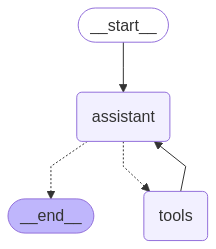

In [126]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Literal
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [129]:
import gradio as gr
import uuid
from datetime import datetime
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage

# from LG_Tutorial import ecommerce_assistant_graph  # Replace with actual module name if different

def simple_chatbot_response(user_input: str):
    thread_id = str(5)
    config = {
    "configurable": {
        # The customer_id is used in our order service tools to
        # fetch the user's order information
        # "customer_id": "38178",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
      }
    }
    state_input = {"messages": [HumanMessage(content=user_input)]}

    try:
        result = react_graph.invoke(state_input,config)
        messages = result["messages"]

        # Extract only final assistant response
        ai_messages = [m.content for m in messages if isinstance(m, AIMessage)]
        return ai_messages[-1] if ai_messages else "Sorry, I couldn't find a final answer."

    except Exception as e:
        return f"❌ Error: {str(e)}"

with gr.Blocks() as demo:
    gr.Markdown("## 🛍️ E-commerce Chatbot (LangGraph + Cohere)")
    chatbot = gr.Chatbot()
    user_input = gr.Textbox(placeholder="Ask something like 'What’s my last order?'")
    send_btn = gr.Button("Send")

    def process_input(input_text, chat_history):
        response = simple_chatbot_response(input_text)
        chat_history.append((input_text, response))
        return "", chat_history

    user_input.submit(process_input, [user_input, chatbot], [user_input, chatbot])
    send_btn.click(process_input, [user_input, chatbot], [user_input, chatbot])

demo.launch(share=False)


C:\Users\goldr\AppData\Local\Temp\ipykernel_11268\627553085.py:35: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7880


INFO:httpx:HTTP Request: GET http://127.0.0.1:7880/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7880/ "HTTP/1.1 200 OK"


* To create a public link, set `share=True` in `launch()`.


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/chat "HTTP/1.1 200 OK"
C:\Users\goldr\AppData\Local\Temp\ipykernel_11268